<h2>GDX price prediction using Ensemble models</h2>
<h3>Usage of linear regression, XGBoosting and artificial neural networks to maximize Sharpe ratio and returns of the algorithm</h3>

In [35]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
import pickle
import keras
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

<h4>Importing the data, performing feature engineering and applying a scaler</h4>

In [33]:
#import data
gdx = pd.read_csv('GDX.csv').drop('Adj Close', axis=1).interpolate(method='linear')
gdx['Date'] = pd.to_datetime(gdx['Date'])

sp500 = pd.read_csv('SPY.csv').drop(['Adj Close', 'Low', 'High', 'Open', 'Volume'], axis=1)
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500.columns = ['Date', 'SP500']

gold = pd.read_csv('gold.csv').iloc[::-1].reset_index().drop('index', axis=1)
gold = gold[gold['Close*'] != '-']
# convert date to datetime
gold['Date'] = pd.to_datetime(gold['Date'])

#merge data
merged = pd.merge(gdx, gold, on='Date')
data = pd.merge(merged, sp500, on='Date').drop('Date', axis=1).interpolate(method='linear')
data.columns = ['GDX open', 'GDX high', 'GDX low', 'GDX close', 'GDX volume', 'Gold close', 'SP500']
data['GDX volume'] = data['GDX volume'].astype(float)
data['Gold close'] = data['Gold close'].str.replace(',', '')
data['Gold close'] = data['Gold close'].astype(float)

data['GDX hist'] = np.nan
data['Diff'] = np.nan
data['Volatility'] = np.nan

ran = 200

for i in range(ran-1, len(data['GDX close'])):
    data['GDX hist'][i] = data['GDX close'][(i-ran):i].mean()
    data['Volatility'][i] = data['GDX close'][(i-ran):i].std()**2

data['Diff'] = (data['GDX close'] - data['GDX hist']) * data['Volatility']

data['y']= data['GDX close'].shift(-1)

data.dropna(inplace=True)

X = data.drop(['y'], axis=1)
X = MinMaxScaler().fit_transform(X)

Y = data['y']

validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

<h4>Checking Mutual information values to maximize the extraction of underlying features</h4>

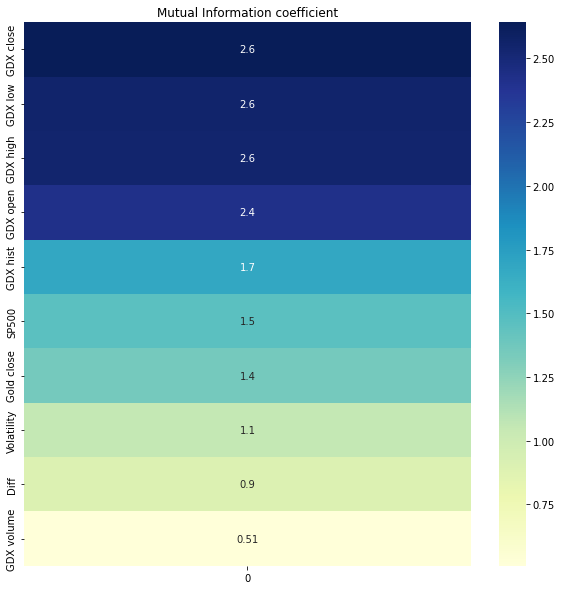

In [34]:
opt1 = 1

if opt1 == 1:
    mi = pd.DataFrame()
    for i in data.columns:
        if i != 'y':
            mi[i] = mutual_info_regression(pd.array(data[i]).reshape(-1, 1), data['y'])

    mi = mi.transpose()
    mi.sort_values(by=0, inplace=True)

    #sort mi
    mi = mi.sort_values(by=0, ascending=False)

    # plot mi
    plt.figure(figsize=(10,10))
    plt.title('Mutual Information coefficient')
    sns.heatmap(mi, annot=True, cmap="YlGnBu")
    plt.show()

<h4>Creating models and predicting over all dataset</h4>

In [56]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(0.3))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mape', optimizer='adam')
    return model

# Fitting the data to model
ann_model = create_model()
ann_model_fit = ann_model.fit(X_train, Y_train,validation_data=(X_test, Y_test), batch_size=128, epochs=400, shuffle=True, verbose=0)

linear_model = LinearRegression().fit(X_train, Y_train)
xgb_model = XGBRegressor(colsample_bytree=.6, subsample=.4, max_depth=4, eta=.1, min_child_weight=10).fit(X_train, Y_train, verbose=False)

# Setting up the data
x_total = np.append(X_train, X_test, axis=0)
y_total = np.append(Y_train, Y_test, axis=0)

# Predict for XGB
pred_xgb = xgb_model.predict(x_total)
# Predict for Linear Regressor
pred_linear = linear_model.predict(x_total)
# Predict for ANN
pred_ann = ann_model.predict(x_total)

<h4>Differentiating dataset and predictions</h4>

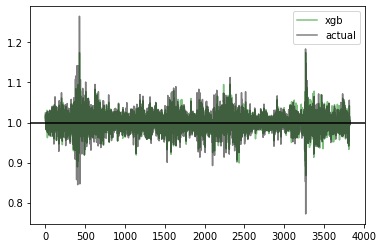

ANN error: 0.02517324911577007
Linear error: 0.027772185956947384
XGB error: 0.02438783309713196


In [57]:
pred1 = pred_ann
pred_dense = list()

for i in range(len(pred1)):
    pred_dense.append(pred1[i][0])

y_total = y_total/np.roll(y_total, 1)
pred_dense = pred_dense/np.roll(pred_dense, 1)
pred_linear = pred_linear/np.roll(pred_linear, 1)
pred_xgb = pred_xgb/np.roll(pred_xgb, 1)


y_total = y_total[1:]
pred_dense = pred_dense[1:]
pred_linear = pred_linear[1:]
pred_xgb = pred_xgb[1:]

skip = 1
# moving average of prediction
pred_dense = np.convolve(pred_dense, np.ones((skip,))/skip, mode='valid')
# moving average of actual
y_total = np.convolve(y_total, np.ones((skip,))/skip, mode='valid')
# moving average of linear
pred_linear = np.convolve(pred_linear, np.ones((skip,))/skip, mode='valid')

#pyplot.plot(pred_linear, color='b',  label='linear', alpha=0.5)
#pyplot.plot(pred_dense, color='r', label='dense', alpha=0.5)
pyplot.plot(pred_xgb, color='g', label='xgb', alpha=0.5)
pyplot.plot(y_total, color='k', label='actual', alpha=0.5)

pyplot.axhline(y=1, color='black', linestyle='-')
pyplot.legend()
pyplot.show()

#print the mape
print('ANN error:', np.mean(np.abs((pred_dense-y_total)/y_total)))
print('Linear error:', np.mean(np.abs((pred_linear-y_total)/y_total)))
print('XGB error:', np.mean(np.abs((pred_xgb-y_total)/y_total)))

<h4>Checking return distribution between real and predicted values</h4>

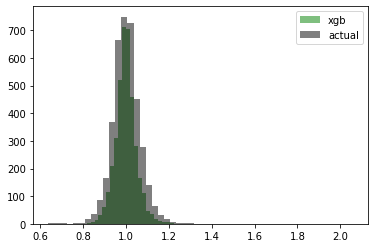

In [55]:
# plot histogram of prediction
#plt.hist(pred_dense, bins=50, color='r', alpha=0.5, label='dense')
#plt.hist(pred_linear, bins=50, color='b', alpha=0.5, label='linear')
plt.hist(pred_xgb, bins=50, color='g', alpha=0.5, label='xgb')
plt.hist(y_total, bins=50, color='k', alpha=0.5, label='actual')
plt.legend()
plt.show()

<h4>Port the results of the predictions to an algorithm and performing backtesting of the 10 prior years</h4>

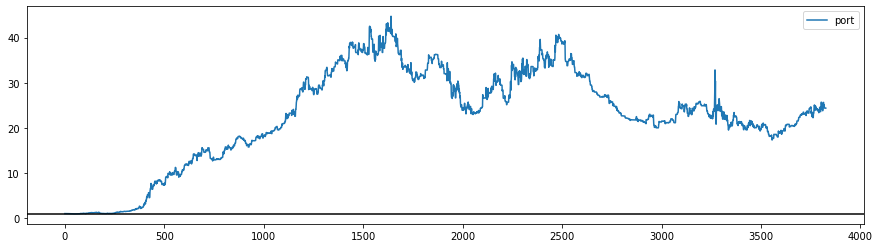

Rendimento 2336.39%
R$24.36 final com R$1.0 de investimento inicial e R$0.0 de investimento diário ao longo de 10 anos e 177 dias
Sharpe Ratio = 2.150569834166052


In [51]:
# Setting treshold
minimum= 1.008
maximum = .985

#Setting configurations
fee = 0.001
alavancagem = 1
c0 = 1
c1 = 0
opt = 0

predF = list()

if opt == 1:
    for i in range(0, len(pred_dense)):
        if (pred_xgb[i] > minimum):
            predF.append(1)
        elif (pred_xgb[i] < maximum):
            predF.append(-1)
        else:
            predF.append(0)
else:
    predF = (0.3*pred_dense+0.1*pred_linear+.6*pred_xgb)
    for i in range(0, len(predF)):
        if predF[i] > minimum:
            predF[i] = 1
        elif predF[i] < maximum:
            predF[i] = -1
        else:
            predF[i] = 0

predF = predF*(y_total-1)

port = list()
port.append(predF[0]+c0)
for i in range(1, len(predF)):
    calc = port[i-1]+alavancagem*port[i-1]*(predF[i])+c1-fee
    if calc > 0:
        port.append(calc)
    else:
        port.append(0)

pyplot.figure(figsize=(15,4))
pyplot.plot(port, label='port')
pyplot.axhline(y=c0, color='black', linestyle='-')
pyplot.legend()
pyplot.show()

print('Rendimento {:.2f}%'.format((port[-1]*100/c0)-100))
print('R${:.2f} final com R${:.1f} de investimento inicial e R${:.1f} de investimento diário ao longo de {:d} anos e {:.0f} dias'.format(port[-1], c0, c1, (len(port)//365), (len(port)/365-(len(port)//365))*365))
print('Sharpe Ratio =', (port[-1]-(1.04**(len(predF)/365)))/np.std(port))

<h2>Conclusions</h2>
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In retrospective, it is clear the potential of different AI models to redefine the way we look at the market. Furthermore we can see that ensemble models are to data science what diversification is to financial markets, a way to make data more predictable and less volatile.</p>
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Regarding the performance of the model, we can see that the first 5 years were espectacular while the rest went sideways, but in general, the model made returns above average. Also, it is important to highlight that this is an exemplification of how the market works since it doesn't account for percentage fees, bid/ask spreads and many other nuances the stock market may have.</p>
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Finally, some additions and changes can be made to maximize performance, such as:</p>
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - Using much more data and features (alternative data, further feature engineering, intraday info)</p>
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - Further hyper-parameter tuning</p>
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - Applying CV(Cross-Validation) to minimize overfitting and induce generalization</p>
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - Ensemble with other types of AI (unsupervised learning, reinforcement learning)</p>
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - Create a portfolio with many algorithms in order to reduce beta and create an algo-diversified portfolio</p>